In [1]:
import os 
import cv2
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support

# Set The Hyperparameter

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

# Split The Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


# Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

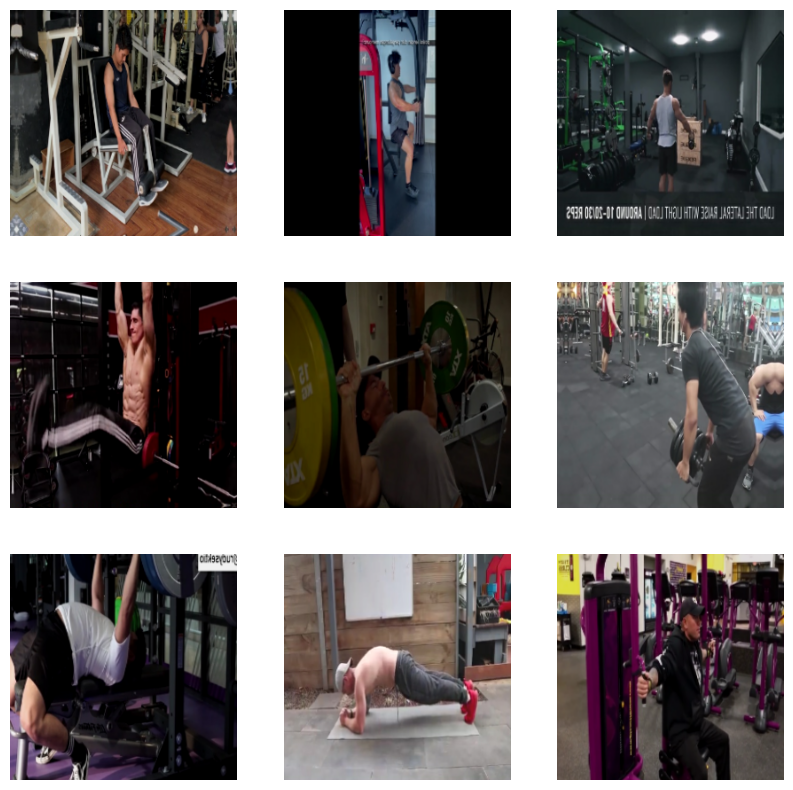

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Load Pre-Trained Model

In [6]:
# load pre-trained InceptionV3
pre_trained = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape, 
    pooling='avg'
)

for layer in pre_trained.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization()(x)

predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Train The Model With Dataset

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks=[early_stopping_callback]
                           )

Epoch 1/100
98/98 [==============================] - 183s 2s/step - loss: 1.7939 - accuracy: 0.5243 - val_loss: 1.6462 - val_accuracy: 0.5300
Epoch 2/100
98/98 [==============================] - 152s 2s/step - loss: 0.9156 - accuracy: 0.7919 - val_loss: 1.1099 - val_accuracy: 0.7271
Epoch 3/100
98/98 [==============================] - 152s 2s/step - loss: 0.6583 - accuracy: 0.8580 - val_loss: 0.9167 - val_accuracy: 0.7762
Epoch 4/100
98/98 [==============================] - 153s 2s/step - loss: 0.5133 - accuracy: 0.8945 - val_loss: 0.7662 - val_accuracy: 0.8094
Epoch 5/100
98/98 [==============================] - 154s 2s/step - loss: 0.4246 - accuracy: 0.9149 - val_loss: 0.6637 - val_accuracy: 0.8433
Epoch 6/100
98/98 [==============================] - 156s 2s/step - loss: 0.3688 - accuracy: 0.9260 - val_loss: 0.5800 - val_accuracy: 0.8643
Epoch 7/100
98/98 [==============================] - 153s 2s/step - loss: 0.3218 - accuracy: 0.9367 - val_loss: 0.5220 - val_accuracy: 0.8773
Epoch 

# Model Evaluation

11/11 [==============================] - 5s 275ms/step - loss: 0.3461 - accuracy: 0.9134


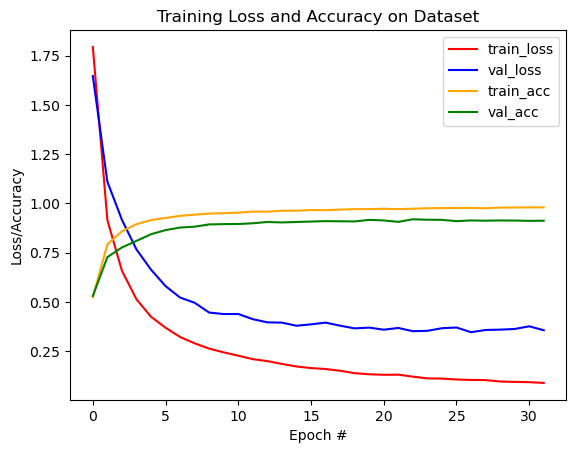

In [9]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save The Model History

In [10]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save The Model

In [11]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

# Testing Model

In [12]:
interpreter = tf.lite.Interpreter(model_path = f'/kaggle/working/workout_model_{current_datetime}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
random_classes_names = random.choice(os.listdir('/kaggle/input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'/kaggle/input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'/kaggle/input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open('/kaggle/working/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

shoulder press/shoulder press_8.mp4

Duration: 4.72
FPS: 25.0
Total frame: 118.0

Prediction process
1, shoulder press
	0.9861358404159546
11, shoulder press
	0.9354150891304016
21, shoulder press
	0.9322540163993835
31, shoulder press
	0.947624146938324
41, shoulder press
	0.9402786493301392
51, shoulder press
	0.8520888686180115
61, shoulder press
	0.8701731562614441
71, shoulder press
	0.8847859501838684
81, shoulder press
	0.8967230916023254
91, shoulder press
	0.9041763544082642

Actual video: shoulder press_8.mp4
Prediction: shoulder press

confidence: 0.9041763544082642
Prediction time: 1.5523221492767334 sec
Scan speed: 0.15523221492767333 per frame



,exercise,percentage
0,shoulder press,9.041764e-01
1,tricep dips,5.650938e-02
2,tricep pushdown,1.694462e-02
3,chest fly machine,1.383193e-02
4,incline bench press,6.029227e-03
5,leg extension,8.469525e-04
6,lateral raises,8.029263e-04
7,hammer curl,3.083690e-04
8,t bar row,2.613075e-04
9,bench press,1.116561e-04
